In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from geopy.distance import vincenty
import math
import datetime

In [2]:
# PARAMETERS

N = 10357 # no of files
nReport = N / 200 # report every 0.5%
bins_dist = np.arange(0,10000+1,500) # bins for the distance PDF
bins_time = np.arange(0,12+0.5,0.5)  # bins for the time difference PDF

degrees_to_radians = math.pi/180.0

In [3]:
# MAIN LOOP
# Since all of the data cannot be concatenated into a sigle dataframe for hist analysis 
# due to memory limitations on my laption, I use hist on individual taxi info and then 
# aggreate them together.

# initialize parameters
nData = 0 
aggCount_dist = np.zeros(len(bins_dist)-1)
aggCount_time = np.zeros(len(bins_time)-1)

startTime = time.time() # start the timer for progress report
for n in xrange(1,N+1):
    
    # read an input file into a dataframe
    taxiDf = pd.read_csv('TaxiData/%s.txt' %n, names = ['no','time1','lat1','long1']) 
    # copy info from next row into current row for easy diff calculations
    taxiDf[['time2','lat2','long2']] = taxiDf.shift(-1)[['time1','lat1','long1']]
    
    # some sanity checks
    taxiDf.dropna(inplace=True)
    taxiDf = taxiDf[taxiDf['time2']>taxiDf['time1']]
    # skip if the file has not valid data points
    if len(taxiDf) == 0: continue
    
    # calculate the distance in meters
    # two approaches: 1) using the geopy module
    #                 2) manual calculation
    # my initial time calculations showed that the latter is 5 times faster, hence, using the manual approach
    # manual calculations
    # equations from http://www.johndcook.com/blog/python_longitude_latitude/
    taxiDf['phi1'] = (90.0 - taxiDf['lat1'])*degrees_to_radians
    taxiDf['phi2'] = (90.0 - taxiDf['lat2'])*degrees_to_radians
    taxiDf['deltaTheta'] = (taxiDf['long1']-taxiDf['long2'])*degrees_to_radians
    taxiDf['cos'] = (np.sin(taxiDf['phi1']) * np.sin(taxiDf['phi2']) * np.cos(taxiDf['deltaTheta']) + np.cos(taxiDf['phi1']) * np.cos(taxiDf['phi2']))
    taxiDf['dist'] = np.arccos(taxiDf['cos']) * 6378.1 * 1000
    # geopy calculations - commented out
    # taxiDf['distFunc'] = taxiDf.apply(lambda row: vincenty((row['lat1'],row['long1']), (row['lat2'],row['long2'])).meters, axis=1)
    
    # calculate the time difference 
    # two approaches: 1) using the built-in functions
    #                 2) manual calculation
    # my initial time calculations showed that the latter is 6 times faster, hence, using the manual approach
    # manual calculations
    taxiDf['day1'] = taxiDf['time1'].str.split(' ').str.get(0).str.split('-').str.get(2).astype(float)
    taxiDf['hr1'] = taxiDf['time1'].str.split(' ').str.get(1).str.split(':').str.get(0).astype(float)
    taxiDf['min1'] = taxiDf['time1'].str.split(' ').str.get(1).str.split(':').str.get(1).astype(float)
    taxiDf['sec1'] = taxiDf['time1'].str.split(' ').str.get(1).str.split(':').str.get(2).astype(float)
    taxiDf['day2'] = taxiDf['time2'].str.split(' ').str.get(0).str.split('-').str.get(2).astype(float)
    taxiDf['hr2'] = taxiDf['time2'].str.split(' ').str.get(1).str.split(':').str.get(0).astype(float)
    taxiDf['min2'] = taxiDf['time2'].str.split(' ').str.get(1).str.split(':').str.get(1).astype(float)
    taxiDf['sec2'] = taxiDf['time2'].str.split(' ').str.get(1).str.split(':').str.get(2).astype(float)
    taxiDf['timeDelta'] = (taxiDf['day2']*1440+taxiDf['hr2']*60+taxiDf['min2']+taxiDf['sec2']*1.0/60.0) - \
                          (taxiDf['day1']*1440+taxiDf['hr1']*60+taxiDf['min1']+taxiDf['sec1']*1.0/60.0)
    # calculation using built-in functions - commented out
    # taxiDf['time1_dt'] = pd.to_datetime(taxiDf['time1'])
    # taxiDf['time2_dt'] = pd.to_datetime(taxiDf['time2'])
    # taxiDf['timeDelta'] = taxiDf.apply(lambda r: (r['time2_dt']-r['time1_dt']).total_seconds()/60.0, axis=1)
    
    # more sanity checks - speed less than 2500 m/min or 150 km/hr
    taxiDf = taxiDf[taxiDf['dist']/taxiDf['timeDelta']<2500]
    
    # add the number of new data points to the previous ones
    nData = nData + len(taxiDf)
    
    # use numpy hist to get the no of data points in each bin - distance
    indCount_dist,division_dist = np.histogram(taxiDf['dist'],bins_dist)    
    aggCount_dist = aggCount_dist + indCount_dist
    
    # use numpy hist to get the no of data points in each bin - time difference
    indCount_time,division_time = np.histogram(taxiDf['timeDelta'],bins_time)
    aggCount_time = aggCount_time + indCount_time 
    
    # progress report
    if n%50 == 0: 
        print '| Progress: %5.1f%% | Time Elapsed: %5.0fs' %(n/float(N)*100, (time.time()-startTime))
        

| Progress:   0.5% | Time Elapsed:     4s
| Progress:   1.0% | Time Elapsed:    10s
| Progress:   1.4% | Time Elapsed:    15s
| Progress:   1.9% | Time Elapsed:    19s
| Progress:   2.4% | Time Elapsed:    24s
| Progress:   2.9% | Time Elapsed:    28s
| Progress:   3.4% | Time Elapsed:    33s
| Progress:   3.9% | Time Elapsed:    40s
| Progress:   4.3% | Time Elapsed:    45s
| Progress:   4.8% | Time Elapsed:    50s
| Progress:   5.3% | Time Elapsed:    55s
| Progress:   5.8% | Time Elapsed:    60s
| Progress:   6.3% | Time Elapsed:    64s
| Progress:   6.8% | Time Elapsed:    69s
| Progress:   7.2% | Time Elapsed:    74s
| Progress:   7.7% | Time Elapsed:    79s
| Progress:   8.2% | Time Elapsed:    83s
| Progress:   8.7% | Time Elapsed:    88s
| Progress:   9.2% | Time Elapsed:    93s
| Progress:   9.7% | Time Elapsed:    98s
| Progress:  10.1% | Time Elapsed:   103s
| Progress:  10.6% | Time Elapsed:   107s
| Progress:  11.1% | Time Elapsed:   114s
| Progress:  11.6% | Time Elapsed:

In [4]:
def myBarChart(x,y,xlabel,ylabel):
    w = (x[1]-x[0])*2/3.0 # bar width 2/3 of the bin width
    fig, ax = plt.subplots()
    fig.set_size_inches(8,5)
    rects1 = ax.bar(x-w/2, y, w, color='r')
    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    ax.set_xticks(x[::2])

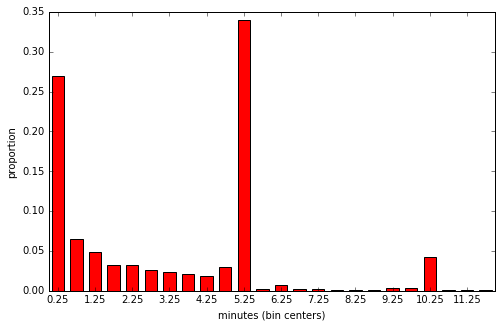

In [5]:
x = np.array(bins_time)[:-1]+0.5/2
y = aggCount_time/nData
myBarChart(x,y,'proportion', 'minutes (bin centers)')

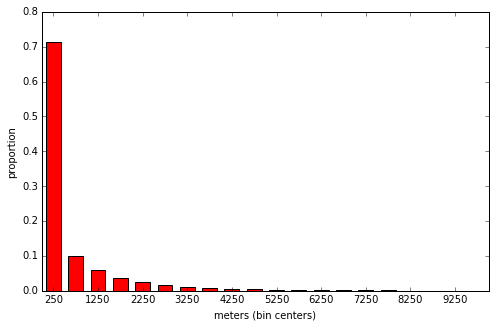

In [6]:
x = np.array(bins_dist)[:-1]+500/2
y = aggCount_dist/nData
myBarChart(x,y,'proportion', 'meters (bin centers)')